# Physical Components of Atmospheric Correction

This notebook demonstrates the physical components of atmospheric correction:

1. **Rayleigh Scattering** - Molecular scattering by atmospheric gases
2. **Gas Absorption** - Absorption by ozone (O3) and nitrogen dioxide (NO2)
3. **Sun Glint** - Specular reflection from the sea surface
4. **Whitecaps** - Foam and whitecap reflectance

These components follow the formulations in **NASA TM-2016-217551** (Mobley et al., 2016).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from correct_atmosphere import constants
from correct_atmosphere import rayleigh
from correct_atmosphere import gases
from correct_atmosphere import glint
from correct_atmosphere import whitecaps

---
## 1. Rayleigh Scattering

Rayleigh scattering is caused by molecules in the atmosphere (primarily N2 and O2). It dominates at shorter wavelengths, giving the sky its blue color.

The Rayleigh optical thickness follows the **Bodhaine et al. (1999)** formulation.

### Rayleigh Optical Thickness

The optical thickness decreases approximately as $\lambda^{-4}$, which is why blue light is scattered much more than red light.

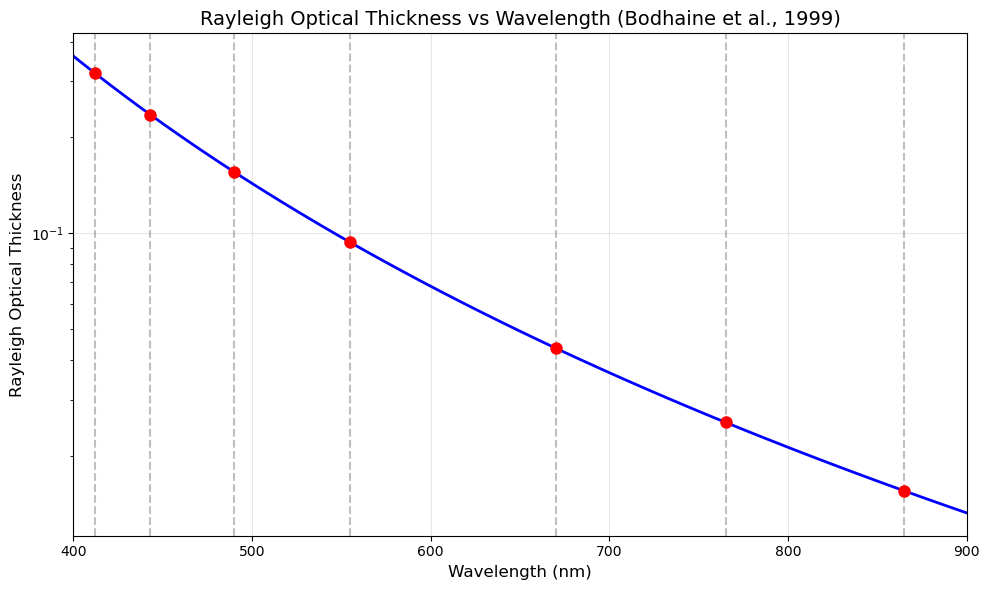

In [2]:
# Calculate Rayleigh optical thickness across visible and NIR wavelengths
wavelengths = np.linspace(400, 900, 100)  # nm
tau_r = np.array([rayleigh.rayleigh_optical_thickness(wl, constants.STANDARD_PRESSURE) 
                  for wl in wavelengths])

plt.figure(figsize=(10, 6))
plt.semilogy(wavelengths, tau_r, 'b-', linewidth=2)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Rayleigh Optical Thickness', fontsize=12)
plt.title('Rayleigh Optical Thickness vs Wavelength (Bodhaine et al., 1999)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(400, 900)

# Mark typical ocean color bands
band_wavelengths = [412, 443, 490, 555, 670, 765, 865]
for wl in band_wavelengths:
    tau = rayleigh.rayleigh_optical_thickness(wl, constants.STANDARD_PRESSURE)
    plt.axvline(wl, color='gray', linestyle='--', alpha=0.5)
    plt.plot(wl, tau, 'ro', markersize=8)

plt.tight_layout()
plt.show()

### Pressure Dependence

Rayleigh optical thickness is proportional to atmospheric pressure. At higher altitudes (lower pressure), there is less molecular scattering.

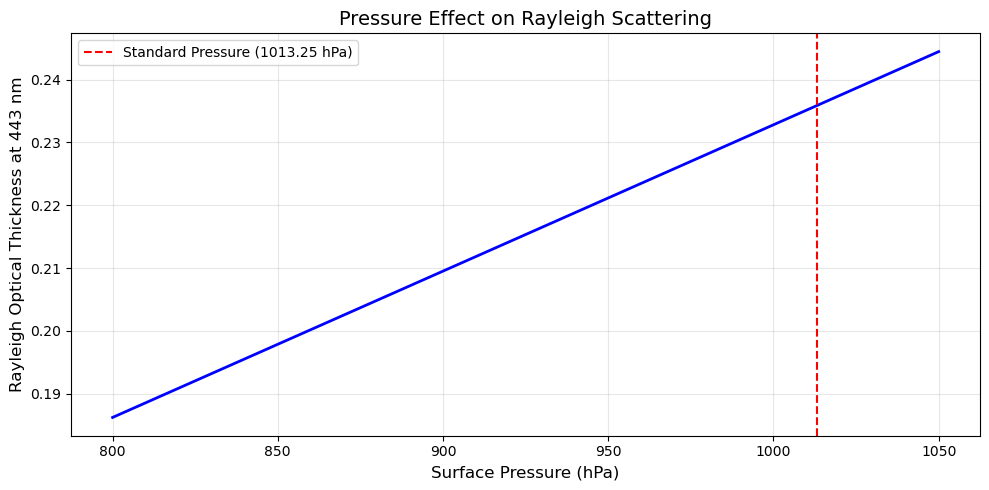

In [3]:
# Effect of pressure on Rayleigh optical thickness
wavelength = 443  # nm (blue band)
pressures = np.linspace(800, 1050, 50)  # hPa

tau_r_pressure = np.array([rayleigh.rayleigh_optical_thickness(wavelength, p) 
                           for p in pressures])

plt.figure(figsize=(10, 5))
plt.plot(pressures, tau_r_pressure, 'b-', linewidth=2)
plt.axvline(constants.STANDARD_PRESSURE, color='r', linestyle='--', 
            label=f'Standard Pressure ({constants.STANDARD_PRESSURE} hPa)')
plt.xlabel('Surface Pressure (hPa)', fontsize=12)
plt.ylabel(f'Rayleigh Optical Thickness at {wavelength} nm', fontsize=12)
plt.title('Pressure Effect on Rayleigh Scattering', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Depolarization Ratio

The depolarization ratio accounts for the non-sphericity of atmospheric molecules and affects the scattering phase function.

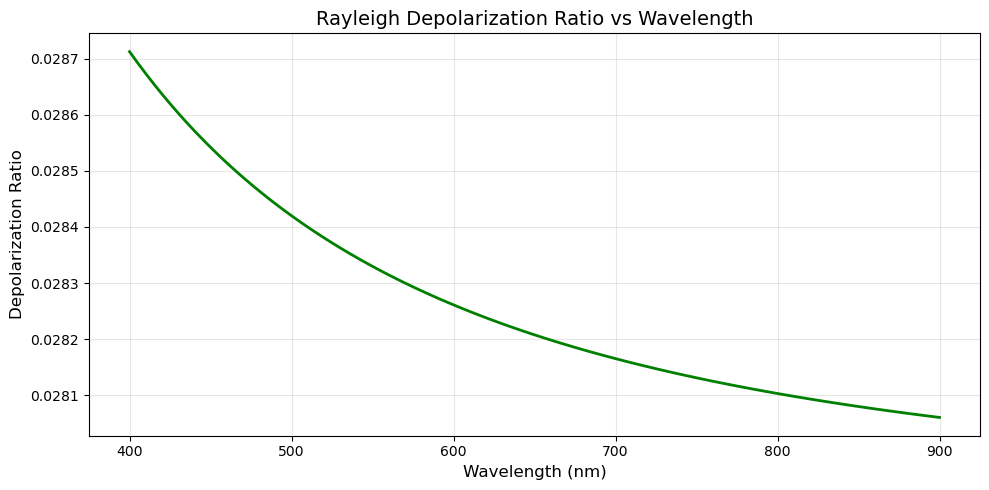

In [4]:
# Depolarization ratio vs wavelength
wavelengths = np.linspace(400, 900, 100)
depol = np.array([rayleigh.rayleigh_depolarization_ratio(wl) for wl in wavelengths])

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, depol, 'g-', linewidth=2)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Depolarization Ratio', fontsize=12)
plt.title('Rayleigh Depolarization Ratio vs Wavelength', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Air Mass Factor

The geometric air mass factor accounts for the path length through the atmosphere:

$$M = \frac{1}{\cos(\theta_s)} + \frac{1}{\cos(\theta_v)}$$

where $\theta_s$ is solar zenith angle and $\theta_v$ is view zenith angle.

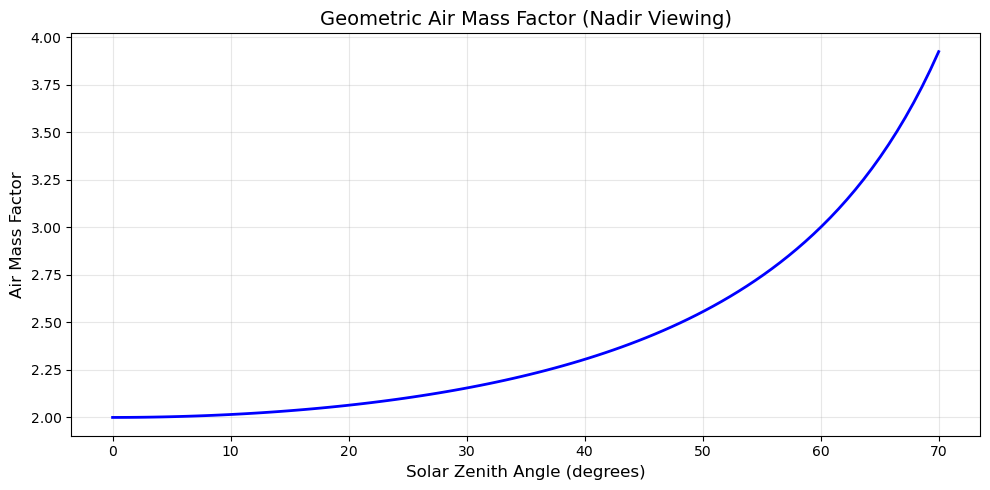

In [5]:
# Air mass factor vs solar zenith angle (for nadir viewing)
solar_zeniths = np.linspace(0, 70, 100)
view_zenith = 0.0  # Nadir viewing

air_mass = np.array([rayleigh.geometric_air_mass_factor(sz, view_zenith) 
                     for sz in solar_zeniths])

plt.figure(figsize=(10, 5))
plt.plot(solar_zeniths, air_mass, 'b-', linewidth=2)
plt.xlabel('Solar Zenith Angle (degrees)', fontsize=12)
plt.ylabel('Air Mass Factor', fontsize=12)
plt.title('Geometric Air Mass Factor (Nadir Viewing)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 2. Gas Absorption

The main absorbing gases in ocean color bands are:
- **Ozone (O3)** - Absorbs strongly in UV and visible (Chappuis band)
- **Nitrogen Dioxide (NO2)** - Absorbs in blue/green wavelengths

### Ozone Absorption

Ozone concentration is measured in Dobson Units (DU). One DU equals 2.69 x 10^16 molecules/cm^2.

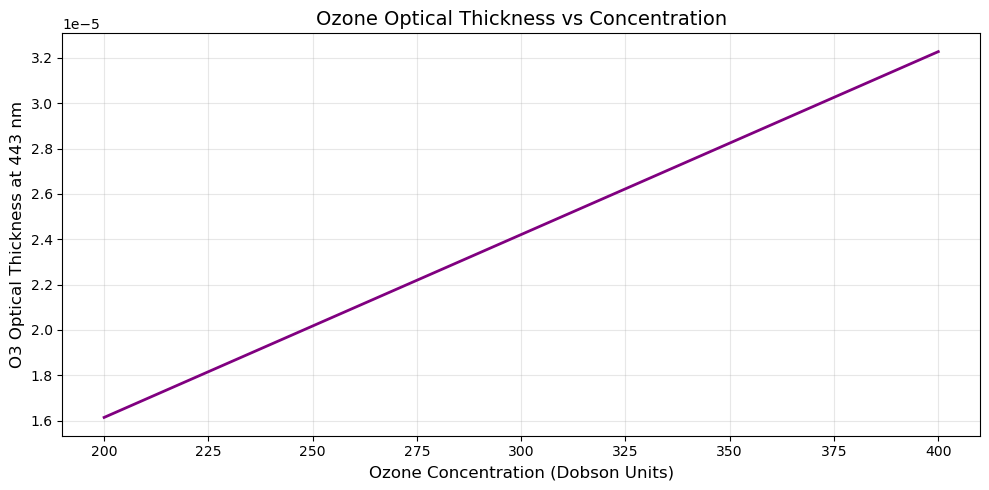

In [6]:
# Ozone optical thickness at different concentrations
wavelength = 443  # nm
o3_concentrations = np.linspace(200, 400, 50)  # Dobson Units

tau_o3 = np.array([gases.ozone_optical_thickness(wavelength, o3) 
                   for o3 in o3_concentrations])

plt.figure(figsize=(10, 5))
plt.plot(o3_concentrations, tau_o3, 'purple', linewidth=2)
plt.xlabel('Ozone Concentration (Dobson Units)', fontsize=12)
plt.ylabel(f'O3 Optical Thickness at {wavelength} nm', fontsize=12)
plt.title('Ozone Optical Thickness vs Concentration', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

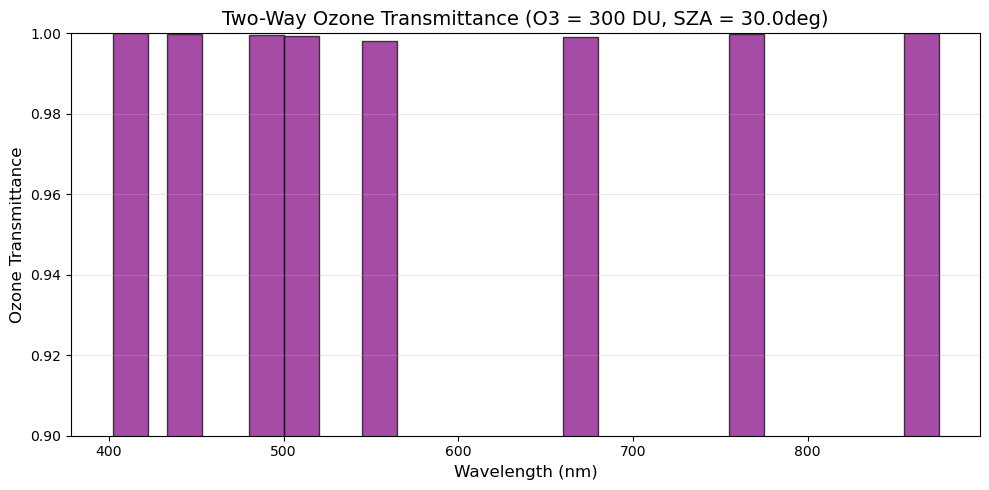

In [7]:
# Ozone transmittance spectrum
wavelengths = np.array([412, 443, 490, 510, 555, 670, 765, 865])
o3_conc = 300  # DU (typical global average)
solar_zenith = 30.0
view_zenith = 15.0

t_o3 = np.array([gases.ozone_transmittance(wl, o3_conc, solar_zenith, view_zenith) 
                 for wl in wavelengths])

plt.figure(figsize=(10, 5))
plt.bar(wavelengths, t_o3, width=20, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Ozone Transmittance', fontsize=12)
plt.title(f'Two-Way Ozone Transmittance (O3 = {o3_conc} DU, SZA = {solar_zenith}deg)', fontsize=14)
plt.ylim(0.9, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### NO2 Absorption

Nitrogen dioxide has significant absorption in the blue wavelengths. The correction accounts for both tropospheric and stratospheric NO2.

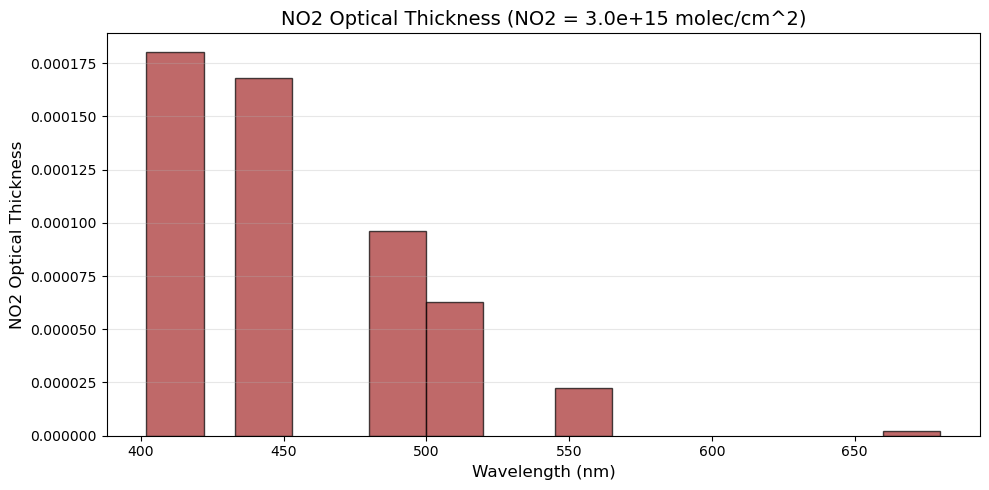

In [8]:
# NO2 optical thickness at different wavelengths
wavelengths = np.array([412, 443, 490, 510, 555, 670])
no2_conc = 3.0e15  # molecules/cm^2 (typical total column)

tau_no2 = np.array([gases.no2_optical_thickness(wl, no2_conc) for wl in wavelengths])

plt.figure(figsize=(10, 5))
plt.bar(wavelengths, tau_no2, width=20, color='brown', alpha=0.7, edgecolor='black')
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('NO2 Optical Thickness', fontsize=12)
plt.title(f'NO2 Optical Thickness (NO2 = {no2_conc:.1e} molec/cm^2)', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Combined Gas Transmittance

The total gaseous transmittance combines O3 and NO2 effects.

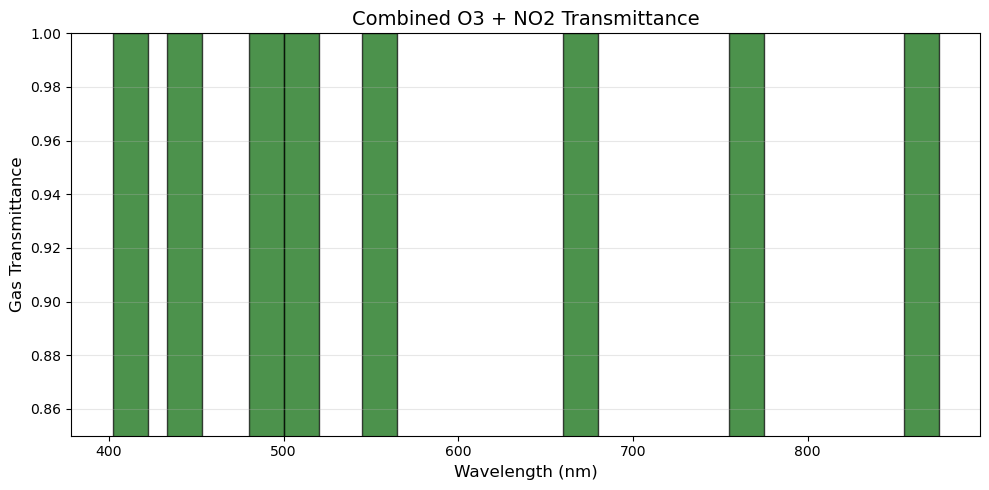

In [9]:
# Combined gas transmittance
wavelengths = np.array([412, 443, 490, 510, 555, 670, 765, 865])
o3_conc = 300  # DU
no2_conc = 3.0e15  # molecules/cm^2
solar_zenith = 30.0
view_zenith = 15.0

t_gas = np.array([gases.gas_transmittance(wl, o3_conc, no2_conc, solar_zenith, view_zenith) 
                  for wl in wavelengths])

plt.figure(figsize=(10, 5))
plt.bar(wavelengths, t_gas, width=20, color='darkgreen', alpha=0.7, edgecolor='black')
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Gas Transmittance', fontsize=12)
plt.title('Combined O3 + NO2 Transmittance', fontsize=14)
plt.ylim(0.85, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---
## 3. Sun Glint

Sun glint is the specular (mirror-like) reflection of sunlight from the sea surface. The **Cox-Munk (1954)** model describes the distribution of wave slopes as a function of wind speed.

### Wave Slope Variance

The mean square slope of ocean waves increases linearly with wind speed.

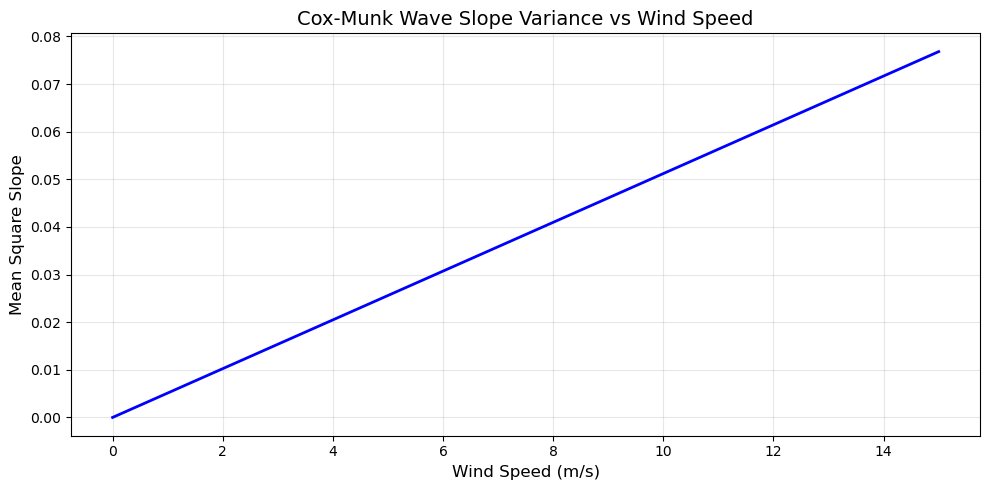

In [10]:
# Cox-Munk wave slope variance
wind_speeds = np.linspace(0, 15, 100)  # m/s
slope_variance = np.array([glint.cox_munk_slope_variance(ws) for ws in wind_speeds])

plt.figure(figsize=(10, 5))
plt.plot(wind_speeds, slope_variance, 'b-', linewidth=2)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Mean Square Slope', fontsize=12)
plt.title('Cox-Munk Wave Slope Variance vs Wind Speed', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Normalized Sun Glint

The normalized sun glint $L_{GN}$ depends on the geometry (sun-sensor-surface angles) and wind speed.

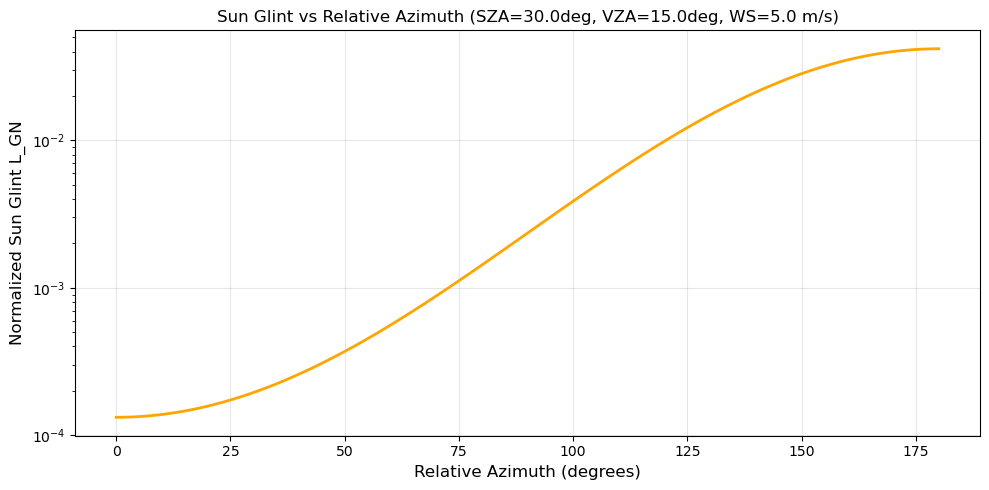

In [11]:
# Sun glint at different geometries
solar_zenith = 30.0
view_zenith = 15.0
wind_speed = 5.0  # m/s

# Vary relative azimuth
rel_azimuths = np.linspace(0, 180, 100)
L_gn = np.array([glint.normalized_sun_glint(solar_zenith, view_zenith, ra, wind_speed) 
                 for ra in rel_azimuths])

plt.figure(figsize=(10, 5))
plt.semilogy(rel_azimuths, L_gn, 'orange', linewidth=2)
plt.xlabel('Relative Azimuth (degrees)', fontsize=12)
plt.ylabel('Normalized Sun Glint L_GN', fontsize=12)
plt.title(f'Sun Glint vs Relative Azimuth (SZA={solar_zenith}deg, VZA={view_zenith}deg, WS={wind_speed} m/s)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

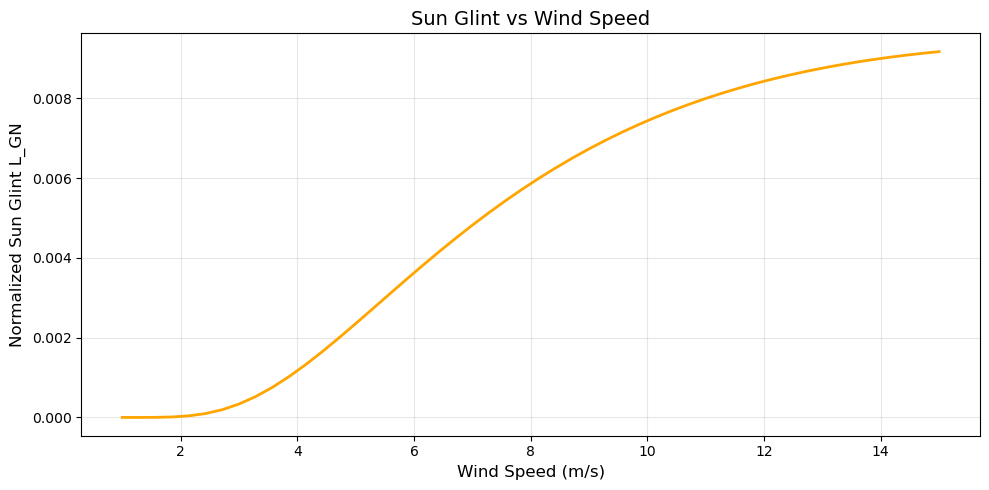

In [12]:
# Effect of wind speed on sun glint
solar_zenith = 30.0
view_zenith = 15.0
rel_azimuth = 90.0  # perpendicular

wind_speeds = np.linspace(1, 15, 50)
L_gn_wind = np.array([glint.normalized_sun_glint(solar_zenith, view_zenith, rel_azimuth, ws) 
                      for ws in wind_speeds])

plt.figure(figsize=(10, 5))
plt.plot(wind_speeds, L_gn_wind, 'orange', linewidth=2)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Normalized Sun Glint L_GN', fontsize=12)
plt.title('Sun Glint vs Wind Speed', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Glint Mask

Pixels with excessive sun glint contamination should be masked. The threshold is typically based on the normalized glint value.

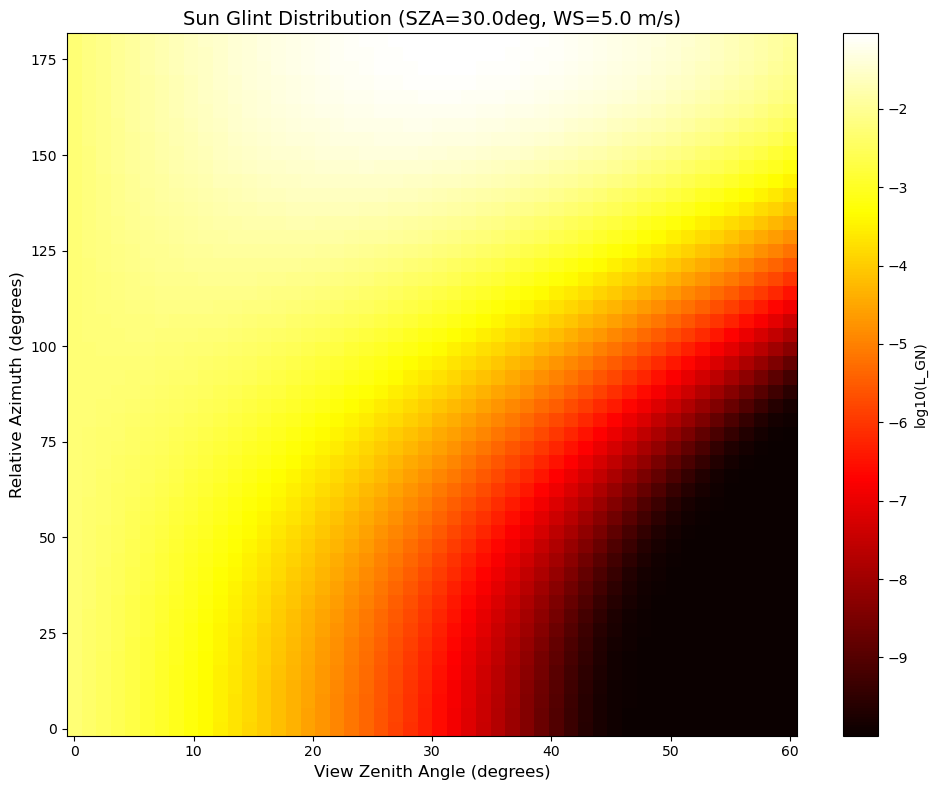

In [13]:
# Create a 2D glint map
solar_zenith = 30.0
wind_speed = 5.0

view_zeniths = np.linspace(0, 60, 50)
rel_azimuths = np.linspace(0, 180, 50)

VZ, RA = np.meshgrid(view_zeniths, rel_azimuths)
L_gn_2d = np.zeros_like(VZ)

for i in range(len(rel_azimuths)):
    for j in range(len(view_zeniths)):
        L_gn_2d[i, j] = glint.normalized_sun_glint(solar_zenith, VZ[i, j], RA[i, j], wind_speed)

plt.figure(figsize=(10, 8))
plt.pcolormesh(view_zeniths, rel_azimuths, np.log10(L_gn_2d + 1e-10), cmap='hot', shading='auto')
plt.colorbar(label='log10(L_GN)')
plt.xlabel('View Zenith Angle (degrees)', fontsize=12)
plt.ylabel('Relative Azimuth (degrees)', fontsize=12)
plt.title(f'Sun Glint Distribution (SZA={solar_zenith}deg, WS={wind_speed} m/s)', fontsize=14)
plt.tight_layout()
plt.show()

---
## 4. Whitecaps and Foam

At higher wind speeds, breaking waves create whitecaps (foam) that contribute to the observed reflectance. The fractional coverage of whitecaps increases with wind speed.

### Whitecap Fraction

Whitecaps typically appear at wind speeds above ~6-7 m/s.

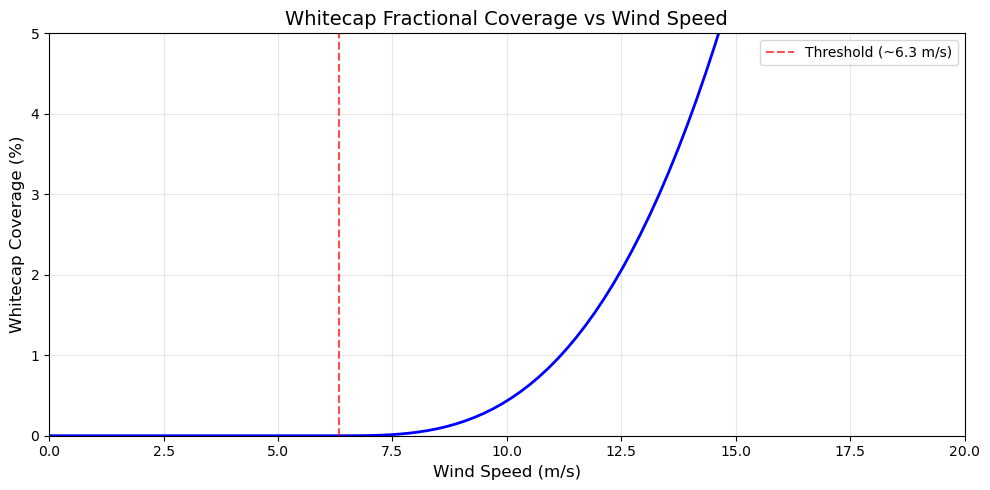

In [14]:
# Whitecap fractional coverage vs wind speed
wind_speeds = np.linspace(0, 20, 100)
wc_fraction = np.array([whitecaps.whitecap_fraction(ws) for ws in wind_speeds])

plt.figure(figsize=(10, 5))
plt.plot(wind_speeds, wc_fraction * 100, 'b-', linewidth=2)
plt.axvline(6.33, color='r', linestyle='--', alpha=0.7, label='Threshold (~6.3 m/s)')
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Whitecap Coverage (%)', fontsize=12)
plt.title('Whitecap Fractional Coverage vs Wind Speed', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 20)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

### Whitecap Reflectance Spectrum

Whitecap reflectance has a weak spectral dependence, being slightly higher at shorter wavelengths.

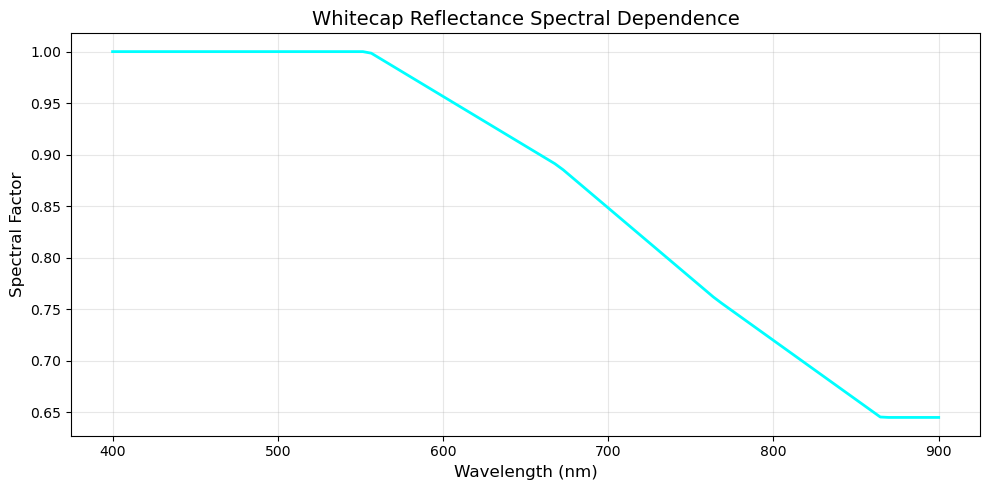

In [15]:
# Whitecap spectral factor
wavelengths = np.linspace(400, 900, 100)
wc_spectral = np.array([whitecaps.whitecap_spectral_factor(wl) for wl in wavelengths])

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, wc_spectral, 'cyan', linewidth=2)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Spectral Factor', fontsize=12)
plt.title('Whitecap Reflectance Spectral Dependence', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Whitecap reflectance at different wind speeds
wavelength = 555  # nm
wind_speeds = np.array([5, 8, 10, 12, 15])

print(f"Whitecap Reflectance at {wavelength} nm:")
print("-" * 40)
for ws in wind_speeds:
    rho_wc = whitecaps.whitecap_reflectance(wavelength, ws)
    frac = whitecaps.whitecap_fraction(ws) * 100
    print(f"  Wind = {ws:2d} m/s: Coverage = {frac:5.2f}%, rho_wc = {rho_wc:.6f}")

Whitecap Reflectance at 555 nm:
----------------------------------------
  Wind =  5 m/s: Coverage =  0.00%, rho_wc = 0.000000
  Wind =  8 m/s: Coverage =  0.04%, rho_wc = 0.000000
  Wind = 10 m/s: Coverage =  0.43%, rho_wc = 0.000000
  Wind = 12 m/s: Coverage =  1.59%, rho_wc = 0.000000
  Wind = 15 m/s: Coverage =  5.70%, rho_wc = 0.000000


---
## Summary: Combined Effects

Let's visualize how these different components contribute to the top-of-atmosphere signal across the spectrum.

/tmp/ipykernel_559562/2843356606.py:51: RuntimeWarning: invalid value encountered in divide
  ax4.plot(wavelengths, rho_whitecap / rho_whitecap.max() * 0.5, 'c-^', label='Whitecap (norm)', linewidth=2)


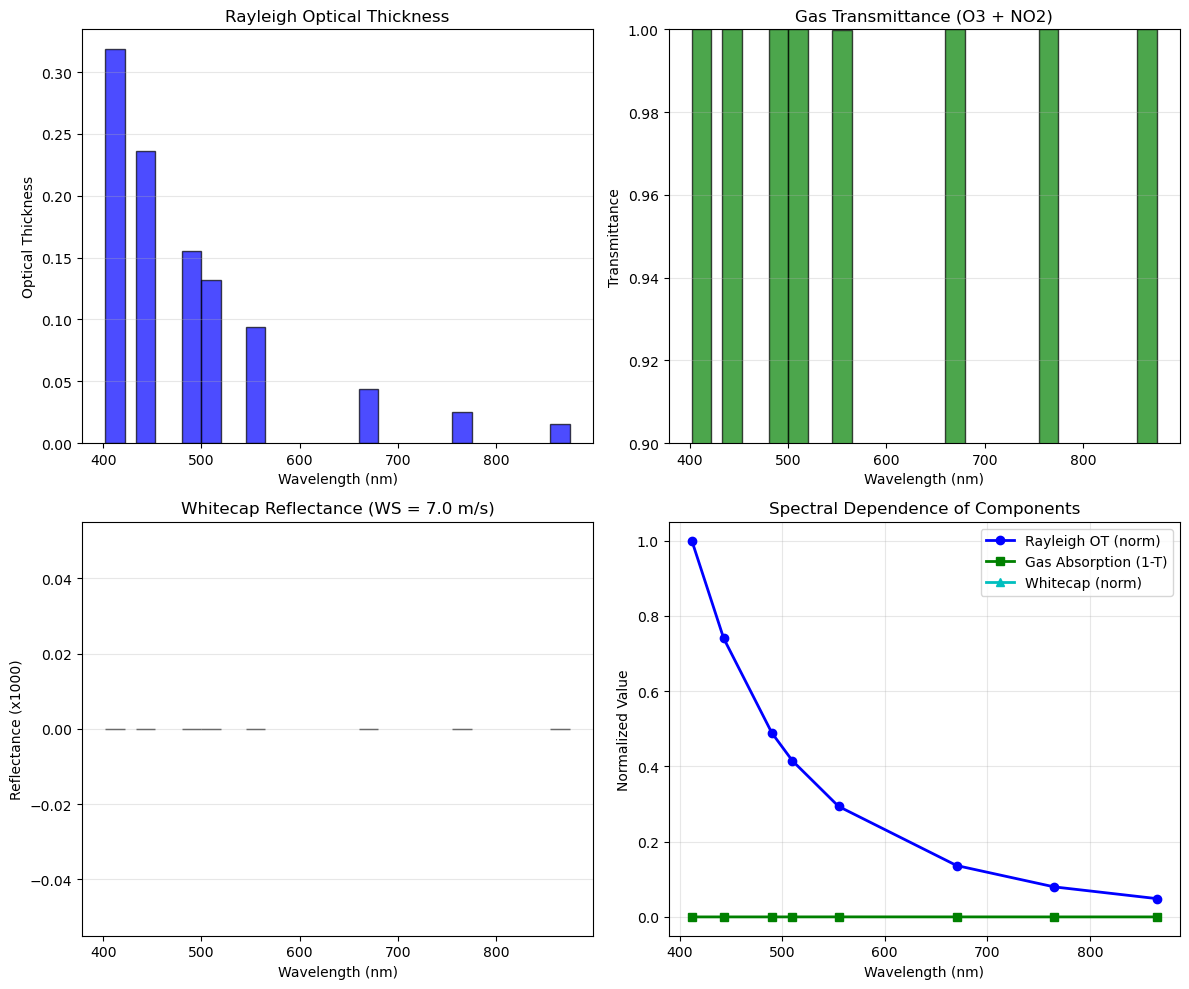

In [17]:
# Typical ocean color wavelengths
wavelengths = np.array([412, 443, 490, 510, 555, 670, 765, 865])

# Typical conditions
pressure = constants.STANDARD_PRESSURE
o3_conc = 300  # DU
no2_conc = 2.0e15  # molecules/cm^2
solar_zenith = 30.0
view_zenith = 15.0
wind_speed = 7.0  # m/s

# Calculate components
tau_rayleigh = np.array([rayleigh.rayleigh_optical_thickness(wl, pressure) for wl in wavelengths])
t_gas = np.array([gases.gas_transmittance(wl, o3_conc, no2_conc, solar_zenith, view_zenith) 
                  for wl in wavelengths])
rho_whitecap = np.array([whitecaps.whitecap_reflectance(wl, wind_speed) for wl in wavelengths])

# Create summary plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Rayleigh optical thickness
ax1 = axes[0, 0]
ax1.bar(wavelengths, tau_rayleigh, width=20, color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Optical Thickness')
ax1.set_title('Rayleigh Optical Thickness')
ax1.grid(True, alpha=0.3, axis='y')

# Gas transmittance
ax2 = axes[0, 1]
ax2.bar(wavelengths, t_gas, width=20, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Transmittance')
ax2.set_title('Gas Transmittance (O3 + NO2)')
ax2.set_ylim(0.9, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

# Whitecap reflectance
ax3 = axes[1, 0]
ax3.bar(wavelengths, rho_whitecap * 1000, width=20, color='cyan', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Reflectance (x1000)')
ax3.set_title(f'Whitecap Reflectance (WS = {wind_speed} m/s)')
ax3.grid(True, alpha=0.3, axis='y')

# Summary: relative importance
ax4 = axes[1, 1]
# Normalize to show relative spectral shapes
ax4.plot(wavelengths, tau_rayleigh / tau_rayleigh.max(), 'b-o', label='Rayleigh OT (norm)', linewidth=2)
ax4.plot(wavelengths, 1 - t_gas, 'g-s', label='Gas Absorption (1-T)', linewidth=2)
ax4.plot(wavelengths, rho_whitecap / rho_whitecap.max() * 0.5, 'c-^', label='Whitecap (norm)', linewidth=2)
ax4.set_xlabel('Wavelength (nm)')
ax4.set_ylabel('Normalized Value')
ax4.set_title('Spectral Dependence of Components')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Rayleigh scattering** dominates at short wavelengths and decreases as $\lambda^{-4}$
2. **Gas absorption** (O3, NO2) has relatively small effects but is wavelength-dependent
3. **Sun glint** depends strongly on geometry and wind speed; must be masked in severe cases
4. **Whitecaps** become significant at wind speeds > 6-7 m/s and have nearly flat spectral response

These components must all be accurately modeled and removed to retrieve the water-leaving radiance.